In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import PIL
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [4]:
df=pd.read_csv('train.csv')

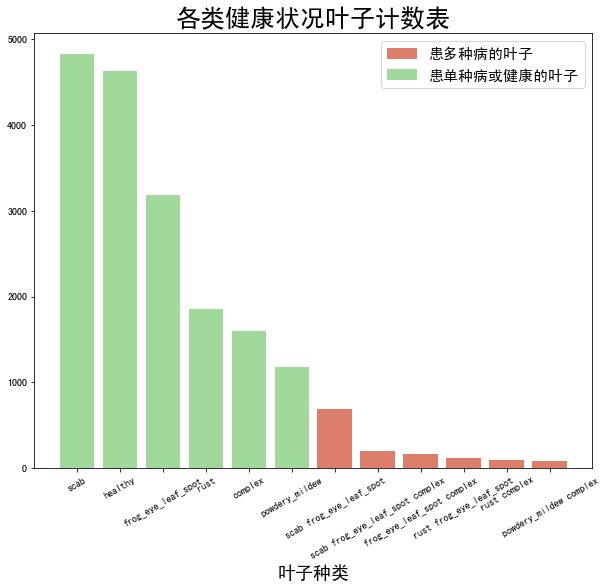

In [5]:
import warnings
plt.rcParams['font.sans-serif']='SimHei'
plt.rcParams['axes.unicode_minus'] = False  # 负号正常显示
warnings.filterwarnings('ignore')

plt.figure(figsize=(10,8))

jibing = df.value_counts("labels").index.tolist()
count = df.value_counts("labels").values.tolist()


single = jibing[0:6]
singlevalue = count[0:6] 
    
multidis = jibing[6:]
multivalue = count[6:]

multi = plt.bar(jibing,count,color='#dd7e6b',label='患多种病的叶子')
sin = plt.bar(single,singlevalue,color='#a0d99a',label='患单种病或健康的叶子')

plt.xlabel('叶子种类',fontsize=18)
plt.xticks(rotation=30)
plt.legend((multi[0], sin[0]), ('患多种病的叶子', '患单种病或健康的叶子'),fontsize=15)
plt.title('各类健康状况叶子计数表',fontsize=25)
plt.show()

[17277, 1355]


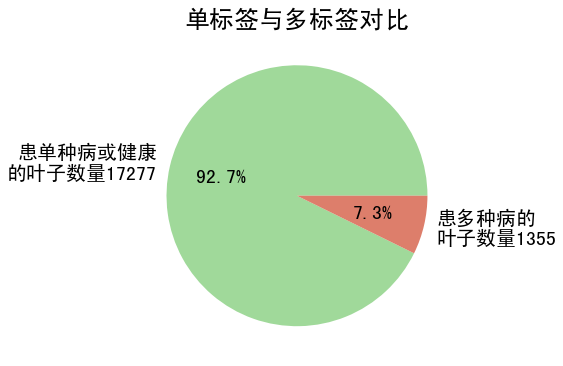

In [6]:
l = list()
l.append(sum(singlevalue))
l.append(sum(multivalue))
print(l)

plt.figure(figsize=(6,6))


last_label = ['患单种病或健康\n的叶子数量17277','患多种病的\n叶子数量1355']
last_colors = ['#a0d99a','#dd7e6b']

patches, texts, autotexts = plt.pie(x=l,labels=last_label,colors=last_colors,labeldistance=1.1,autopct='%1.1f%%')
plt.setp(autotexts, size=20)
plt.setp(texts, size=20)
plt.title('单标签与多标签对比', size=25)
plt.show()

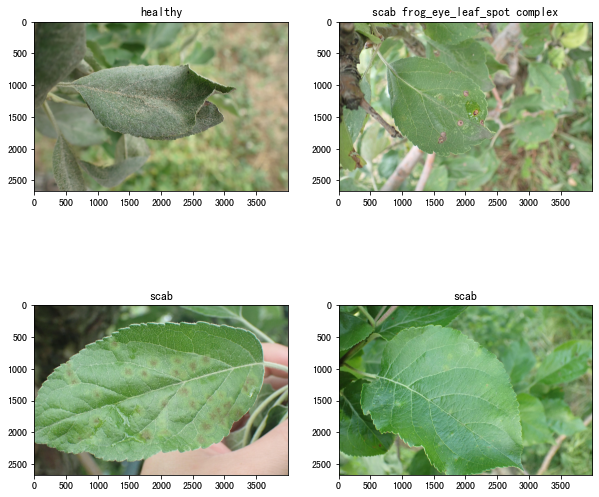

In [7]:
train_path="train_images"
plt.figure(figsize=(10,20))
i=1
for idx,s in df.head(4).iterrows():
    img_path = os.path.join(train_path,s['image'])
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    fig=plt.subplot(4,2,i)
    fig.imshow(img)
    fig.set_title(s['labels'])
    i+=1

In [8]:
df['labels']=df['labels'].apply( lambda string: string.split(' ') )
df.head()

,image,labels
0,800113bb65efe69e.jpg,[healthy]
1,8002cb321f8bfcdf.jpg,"[scab, frog_eye_leaf_spot, complex]"
2,80070f7fb5e2ccaa.jpg,[scab]
3,80077517781fb94f.jpg,[scab]
4,800cbf0ff87721f8.jpg,[complex]


In [9]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
hot_labels = mlb.fit_transform(df['labels'])
print(mlb.classes_)
print(hot_labels)

['complex' 'frog_eye_leaf_spot' 'healthy' 'powdery_mildew' 'rust' 'scab']
[[0 0 1 0 0 0]
 [1 1 0 0 0 1]
 [0 0 0 0 0 1]
 ...
 [0 0 0 0 1 0]
 [0 1 0 0 0 1]
 [0 0 1 0 0 0]]


In [10]:
df_labels = pd.DataFrame(hot_labels,columns=mlb.classes_,index=df.index)
df_labels

,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab
0,0,0,1,0,0,0
1,1,1,0,0,0,1
2,0,0,0,0,0,1
3,0,0,0,0,0,1
4,1,0,0,0,0,0
...,...,...,...,...,...,...
18627,0,0,1,0,0,0
18628,0,0,0,0,0,1
18629,0,0,0,0,1,0
18630,0,1,0,0,0,1


['complex', 'frog_eye_leaf_spot', 'powdery_mildew', 'rust', 'scab']


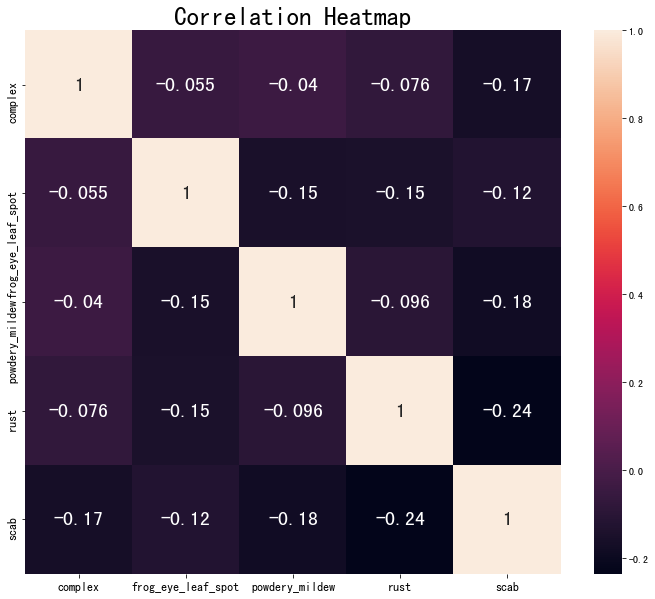

In [11]:
# heatmap
df_stat = df_labels[['complex','frog_eye_leaf_spot','powdery_mildew','rust','scab']]
plt.subplots(figsize=(12,10))
ax = plt.axes()
ax.set_title("Correlation Heatmap")
plt.title('Correlation Heatmap',fontsize=25)
corr = df_stat.corr()
sns.heatmap(corr,annot=True,annot_kws={'size':20,'weight':'bold'},
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)


plt.tick_params(labelsize=12) 
print(corr.columns.values.tolist())

In [12]:
from scipy.stats import chi2
from scipy.stats import chi2_contingency

In [13]:
def chi2_independence(alpha, data):
    g, p, dof, expctd = chi2_contingency(data)
    if dof == 0:
        print('自由度应该大于等于1')
    elif dof == 1:
        cv = chi2.isf(alpha * 0.5, dof)
    else:
        cv = chi2.isf(alpha * 0.5, dof-1)
    if g > cv:
        re = 1  # 表示拒绝原假设
    else:
        re = 0  # 表示接受原假设
    
    return g, p, dof, re, expctd

In [14]:
alpha1 = 0.05  # 置信度
labels = corr.columns.values.tolist()
df_stat = df_labels[['complex','frog_eye_leaf_spot','powdery_mildew','rust','scab']]
for i in range(0,5):
    for j in range(i+1,5):
        d1 = df_stat[labels[i]].tolist()
        d1 = [i+1e-10 for i in d1]
        d2 = df_stat[labels[j]].tolist()
        d2 = [i+1e-10 for i in d2]
        data = np.array([d1,d2])
        g, p, dof, re, expctd = chi2_independence(alpha1, data)
        if re==1:
            str1 = '拒绝原假设，不认为'
        if re==0:
            str1 = '接受原假设，认为'
        print(labels[i]+'与'+labels[j]+'的独立性检验中：p值为：'+str(p)+'，因此'+str1+labels[i]+'与'+labels[j]+'相互独立')

complex与frog_eye_leaf_spot的独立性检验中：p值为：1.0，因此接受原假设，认为complex与frog_eye_leaf_spot相互独立
complex与powdery_mildew的独立性检验中：p值为：1.0，因此接受原假设，认为complex与powdery_mildew相互独立
complex与rust的独立性检验中：p值为：1.0，因此接受原假设，认为complex与rust相互独立
complex与scab的独立性检验中：p值为：1.0，因此接受原假设，认为complex与scab相互独立
frog_eye_leaf_spot与powdery_mildew的独立性检验中：p值为：1.0，因此接受原假设，认为frog_eye_leaf_spot与powdery_mildew相互独立
frog_eye_leaf_spot与rust的独立性检验中：p值为：1.0，因此接受原假设，认为frog_eye_leaf_spot与rust相互独立
frog_eye_leaf_spot与scab的独立性检验中：p值为：1.0，因此接受原假设，认为frog_eye_leaf_spot与scab相互独立
powdery_mildew与rust的独立性检验中：p值为：1.0，因此接受原假设，认为powdery_mildew与rust相互独立
powdery_mildew与scab的独立性检验中：p值为：1.0，因此接受原假设，认为powdery_mildew与scab相互独立
rust与scab的独立性检验中：p值为：1.0，因此接受原假设，认为rust与scab相互独立
